# Main

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from skimage.color import rgb2gray, gray2rgb

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys  
sys.path.insert(0, '.')

# helper functions and constants
import utils

# explanation functions
import explanations as expl

2023-03-16 20:07:40.393410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# extract & preprocess data
ecg, diags = utils.read_hcu_data()
X_ecg = utils.preprocess_ecg(ecg)
Y_ground = utils.extract_ground_truth(diags)

# load model
model = utils.load_ribeiro_model()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2286/2286 [00:00<00:00, 69780.93it/s]
2023-03-16 20:09:20.916891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 20:09:20.917148: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
Y_ecg = model.predict(X_ecg)

72/72 [==============================] - 86s 1s/step


## Adapting the blackbox model

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [6]:
print('F1 Score for black-box model:', '\n')
for i in range(6) :
    print(utils.LABELS[i], '\t', f1_score(Y_ground[:, i], Y_ecg[:, i] > 0.5))

F1 Score for black-box model: 

1dAVb 	 0.7737704918032787
RBBB 	 0.8410256410256411
LBBB 	 0.8398791540785498
SB 	 0.24271844660194178
AF 	 0.7199999999999999
ST 	 0.8402366863905326


In [69]:
X_train, X_test, Y_train, Y_test = train_test_split(Y_ecg, Y_ground, test_size=0.2, stratify=Y_ground[:, 4], random_state=1234)

F1 score cross validation of RF adaptors:
1dAVb 	 [0.8        0.8        0.82926829 0.93333333 0.94594595]
RBBB 	 [0.64705882 0.70588235 0.64615385 0.75471698 0.97560976]
LBBB 	 [0.81690141 0.79452055 0.77142857 0.96551724 0.98305085]
SB 	 [0.82352941 0.8045977  0.81176471 0.88461538 0.94193548]
AF 	 [0.3255814  0.37037037 0.57142857 0.66666667 0.76923077]
ST 	 [0.91891892 0.88235294 0.85714286 0.89473684 0.97142857]


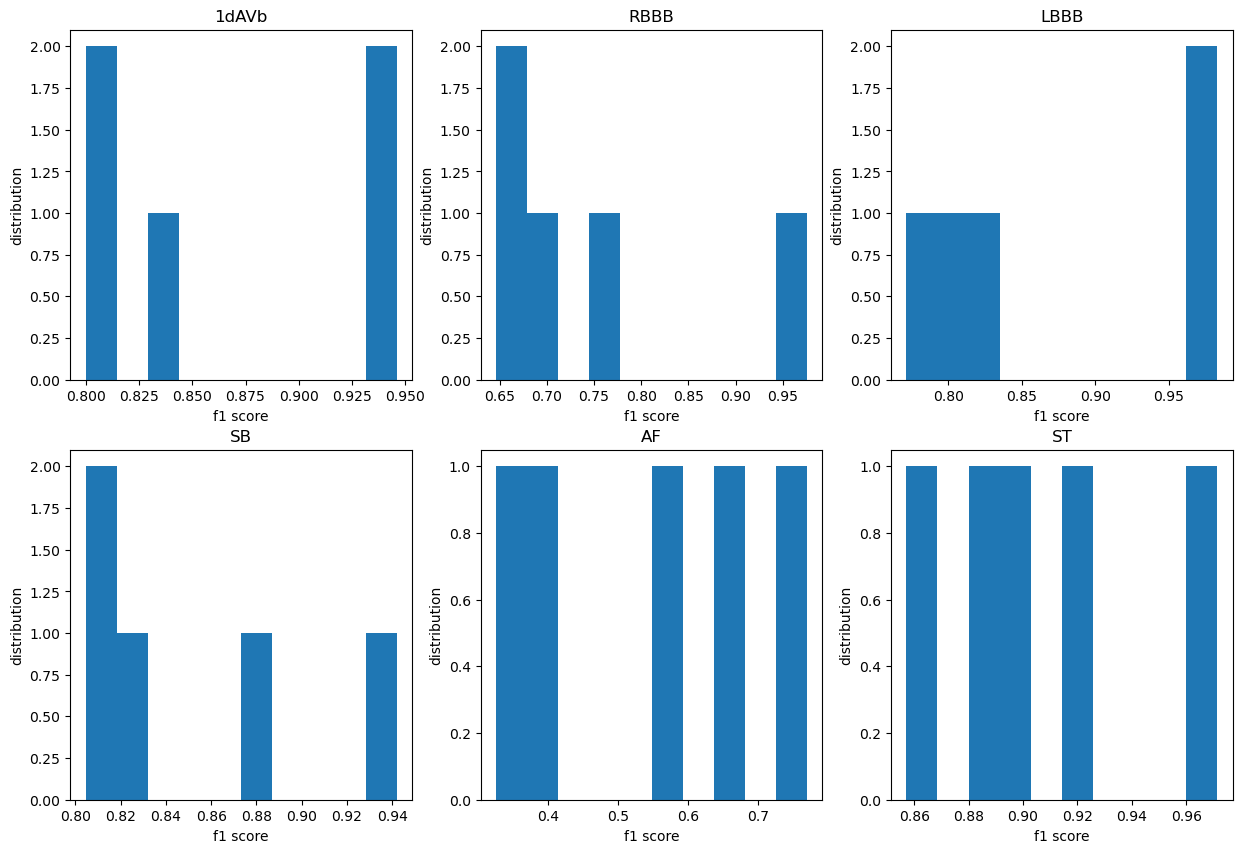

In [117]:
print('F1 score cross validation of RF adaptors:')
_, axs = plt.subplots(nrows = 2, ncols = 3, figsize=(15, 10))
for i in range(6):
    # dtree = RandomForestClassifier(n_estimators=100,  class_weight='balanced')
    dtree = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
    cvs = cross_val_score(dtree, Y_ecg, Y_ground[:, i], scoring='f1', )
    print(utils.LABELS[i],'\t', cvs)
    ax = axs[i // 3, i % 3]
    ax.hist(cvs)
    ax.set_title(utils.LABELS[i])
    ax.set_ylabel('distribution')
    ax.set_xlabel('f1 score')

plt.savefig('cross_val_score_dtree')
plt.show()

In [148]:
dtrees = utils.fit_adaptors(X_train, Y_train, DecisionTreeClassifier, max_depth=5, class_weight='balanced')

In [149]:
print('F1 score of dtrees')
for i in range(6):
    print(utils.LABELS[i], '\t', f1_score(Y_test[:, i], dtrees[i].predict(X_test)))

F1 score of dtrees
1dAVb 	 0.8444444444444446
RBBB 	 0.819672131147541
LBBB 	 0.8400000000000001
SB 	 0.8571428571428571
AF 	 0.631578947368421
ST 	 0.9230769230769231


In [64]:
print('F1 score of dtrees')
for i in range(6):
    print(utils.LABELS[i], '\t', f1_score(Y_test[:, i], dtrees[i].predict(X_test)))

F1 score of dtrees
1dAVb 	 0.7710843373493975
RBBB 	 0.7169811320754718
LBBB 	 0.8400000000000001
SB 	 0.832214765100671
AF 	 0.6
ST 	 0.8717948717948718


## LIME

In [165]:
def predict_img(X):
    X_ecg = model.predict(rgb2gray(X), verbose = False)
    return X_ecg

In [137]:
def predict_img_adapt(X, adaptors):
    X_ecg = model.predict(rgb2gray(X), verbose = False)
    res = np.array([a.predict_proba(X_ecg) for a in adaptors])
    res =  res[..., 1].T
    # print(res.shape)
    return res

In [166]:
lime_expl = expl.extract_lime_explanation(X_ecg[50], predict_img)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


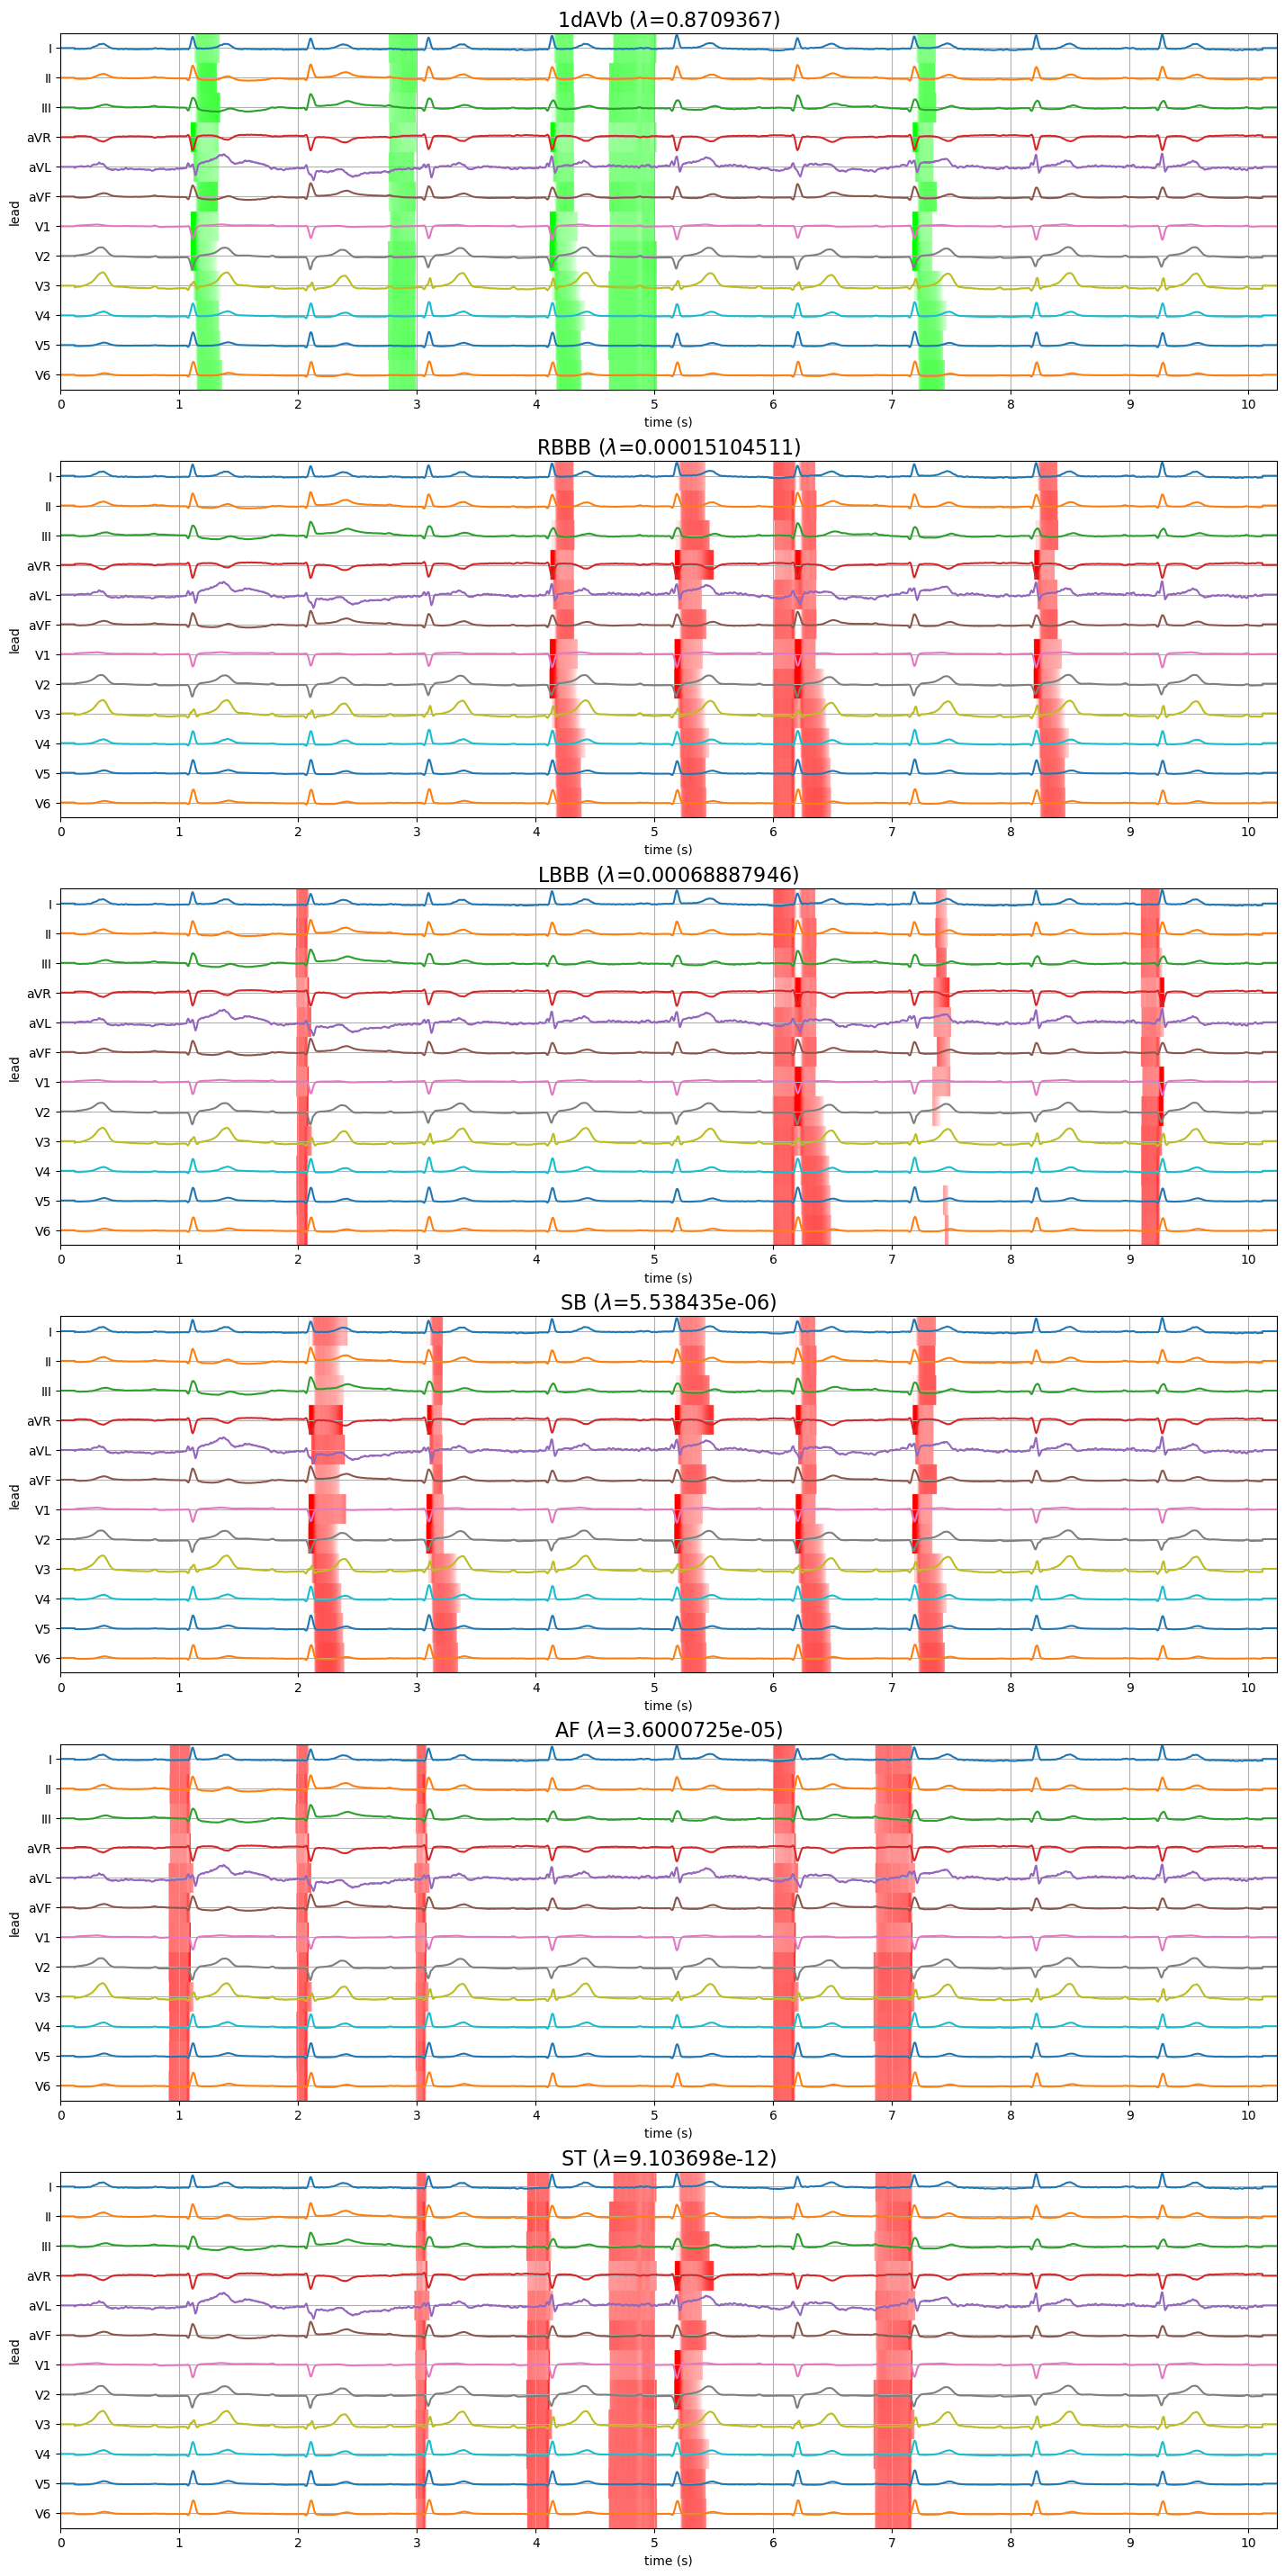

In [167]:
expl.visualize_explanation(**lime_expl, vmin=None, vmax=None, cmap=None, labels=None)

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


None None
(1200, 4096, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1200, 4096, 3)
(1200, 4096, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1200, 4096, 3)
(1200, 4096, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1200, 4096, 3)


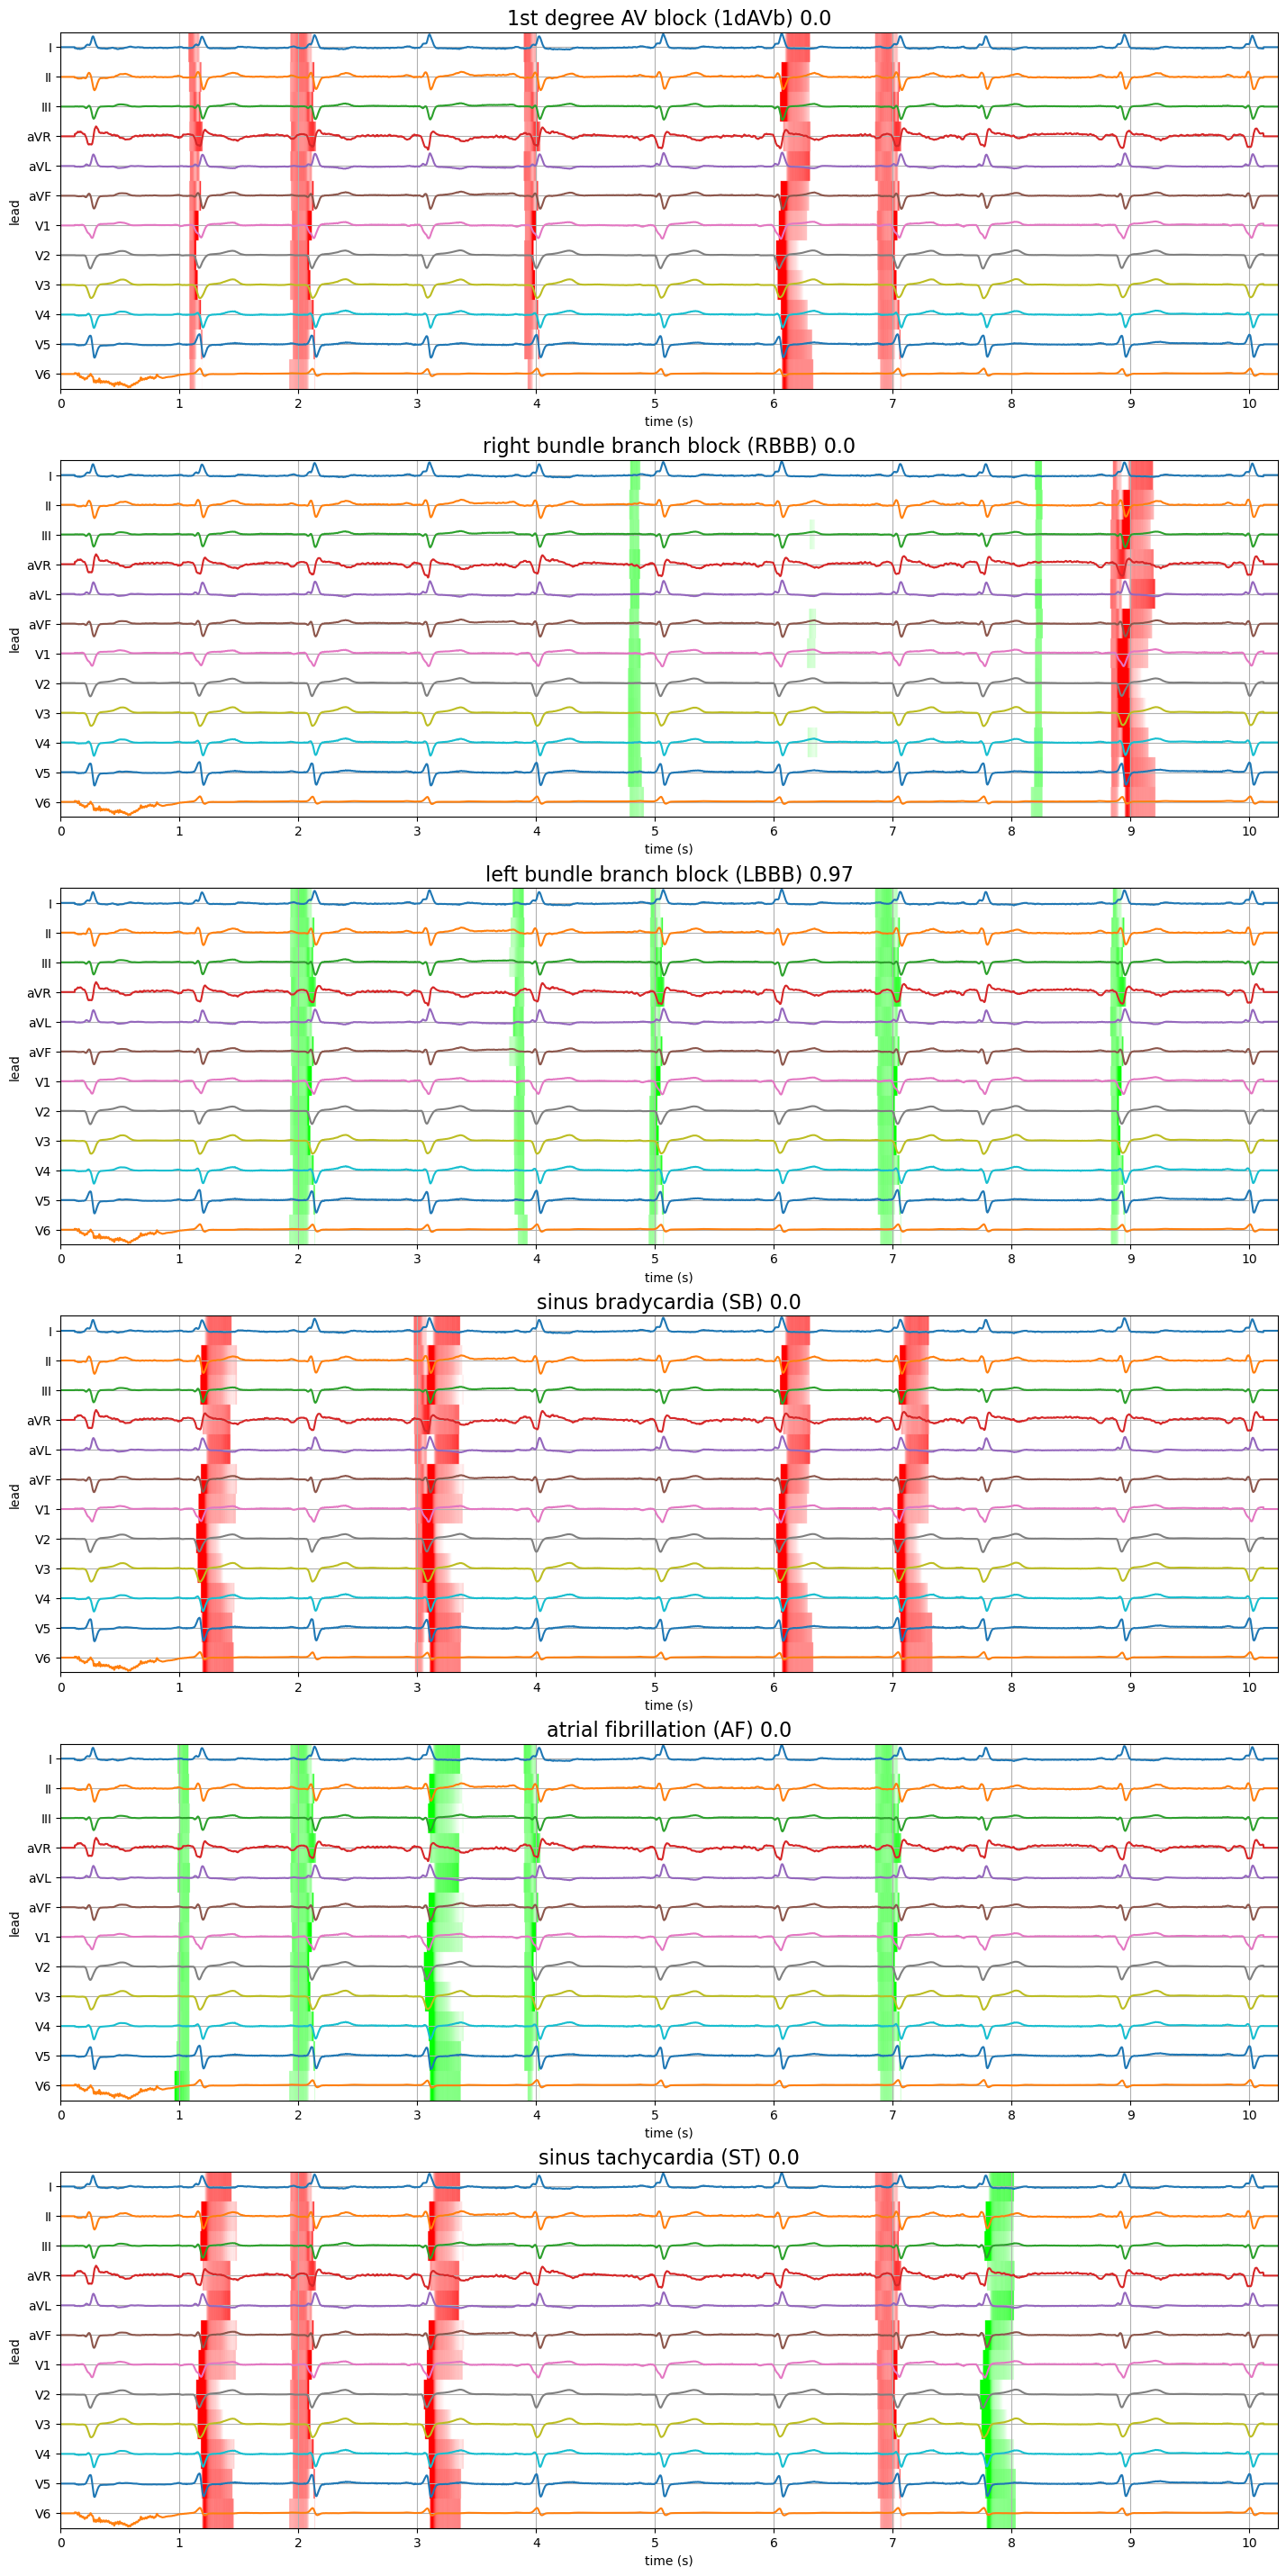

In [136]:
visualize_lime(X_ecg[803])

In [86]:
Y_ecg[195]

array([1.5285954e-05, 5.8138710e-05, 6.3190839e-08, 7.9911029e-01,
       2.5883222e-07, 1.1223479e-12], dtype=float32)

In [ ]:
dtrees[3].predict([Y_ecg[195]])

In [17]:
Y[50]

array([8.7093669e-01, 1.5104511e-04, 6.8887946e-04, 5.5384298e-06,
       3.6000725e-05, 9.1036805e-12], dtype=float32)

## Shap

In [66]:
import shap
shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough

In [41]:
np.random.choice(np.arange(len(X_ecg))[Y_ground[:, 2] == 1])

803

In [159]:
shap_expl = expl.extract_shap_partition_explanation(X_ecg[50], lambda X: predict_img_adapt(X, dtrees))

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [03:45, 225.60s/it]                                                                                                                                                                                                  


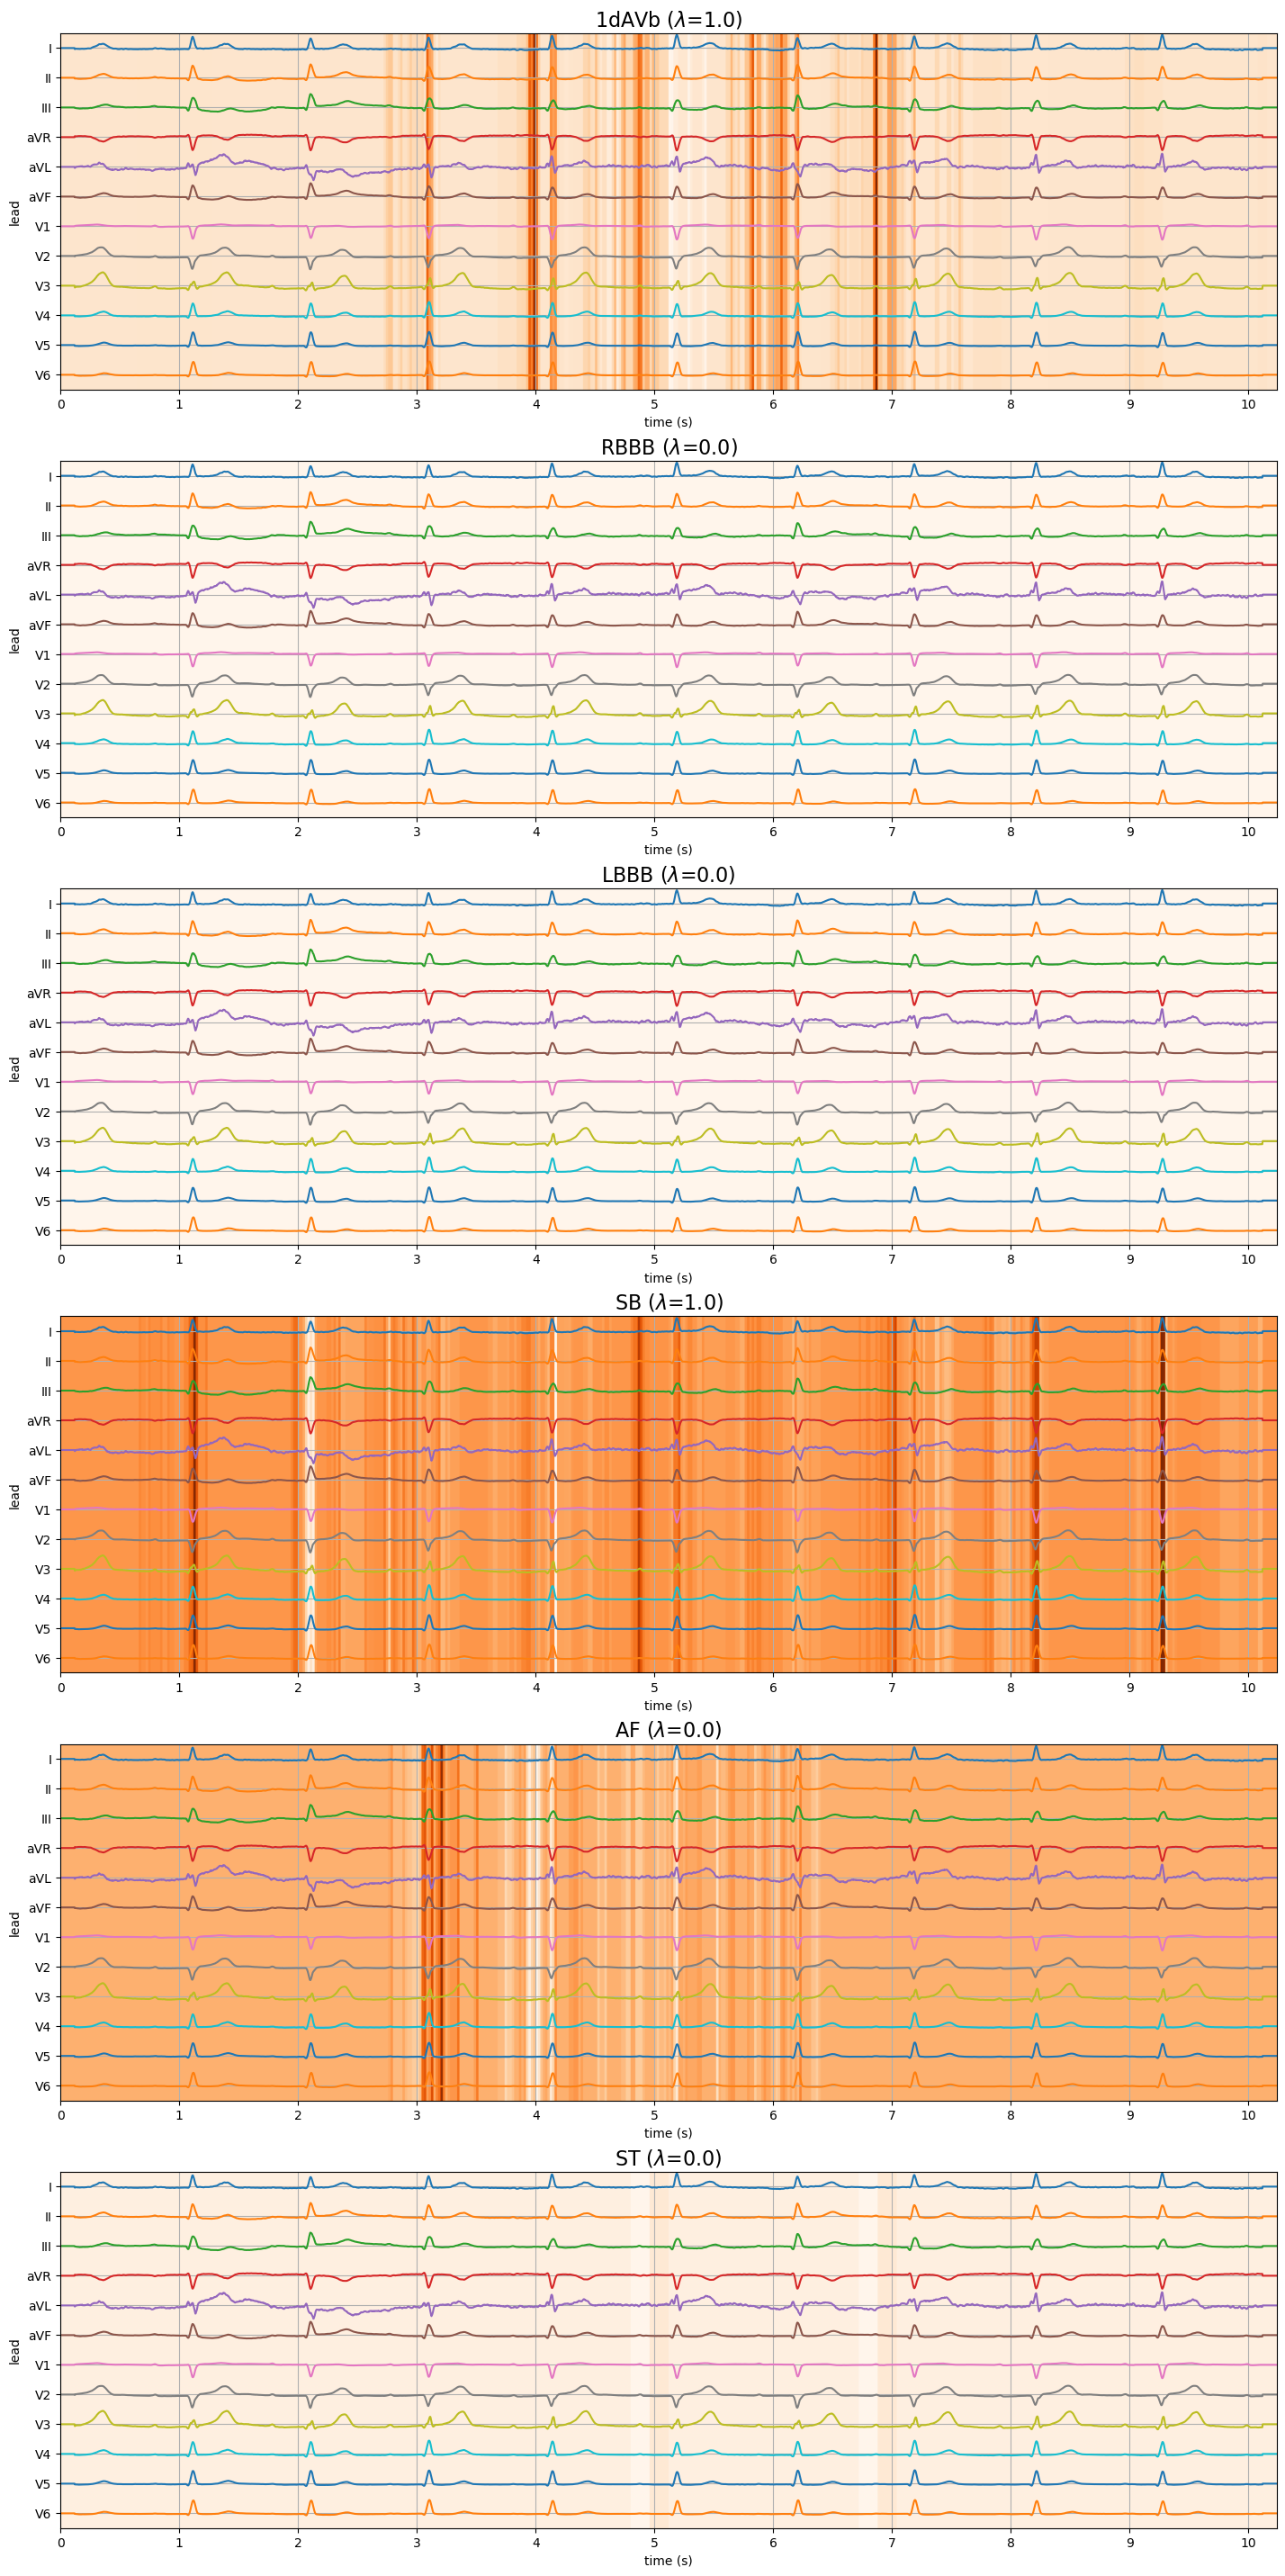

In [160]:
expl.visualize_explanation(**shap_expl, cmap='Oranges', labels=None)

In [145]:
shapd_bkgd = X_ecg[np.random.choice(X_ecg.shape[0], 100, replace=False)]

In [147]:
shapd_expl = expl.extract_shap_deep_explanation(X_ecg[803], model, shapd_bkgd)

KeyboardInterrupt: 

In [ ]:
expl.visualize_explanation(**shapd_expl, lead=None, labels=2)

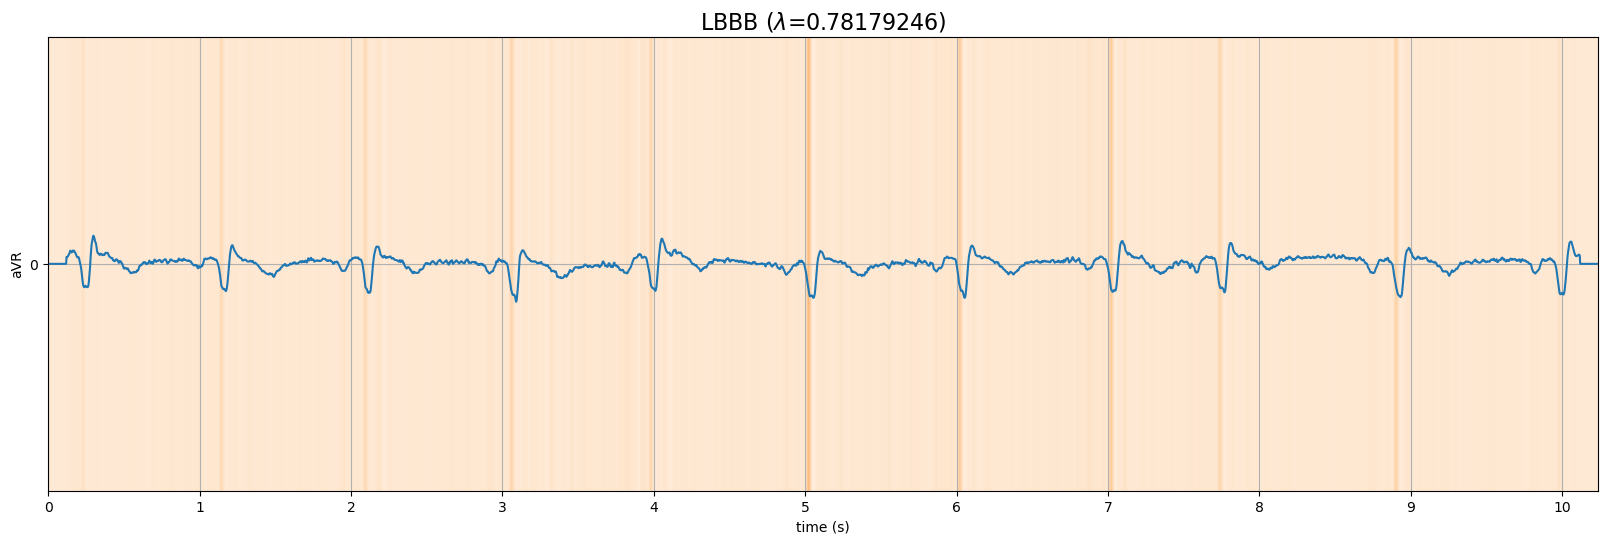

In [99]:
expl.visualize_explanation(**shapd_expl, lead=3, labels=2)

In [42]:
Y_ecg[803]

array([9.2355418e-04, 7.6057384e-04, 7.8179240e-01, 5.8079699e-05,
       2.4322404e-04, 2.4971449e-05], dtype=float32)

In [235]:
Y_ground[50]

array([ True, False, False,  True, False, False])

In [ ]:
visualize_shap(X_ecg[50])

  0%|          | 0/4998 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [03:54, 234.94s/it]                                                                                                                                                                                                  


['1st degree AV block (1dAVb)', 'right bundle branch block (RBBB)', 'left bundle branch block (LBBB)', 'sinus bradycardia (SB)', 'atrial fibrillation (AF)', 'sinus tachycardia (ST)']
(1, 4096, 12, 3, 6)
(4096, 1)
(1200, 4096)
(4096, 1)
(1200, 4096)
(4096, 1)
(1200, 4096)
(4096, 1)
(1200, 4096)
(4096, 1)
(1200, 4096)
(4096, 1)
(1200, 4096)


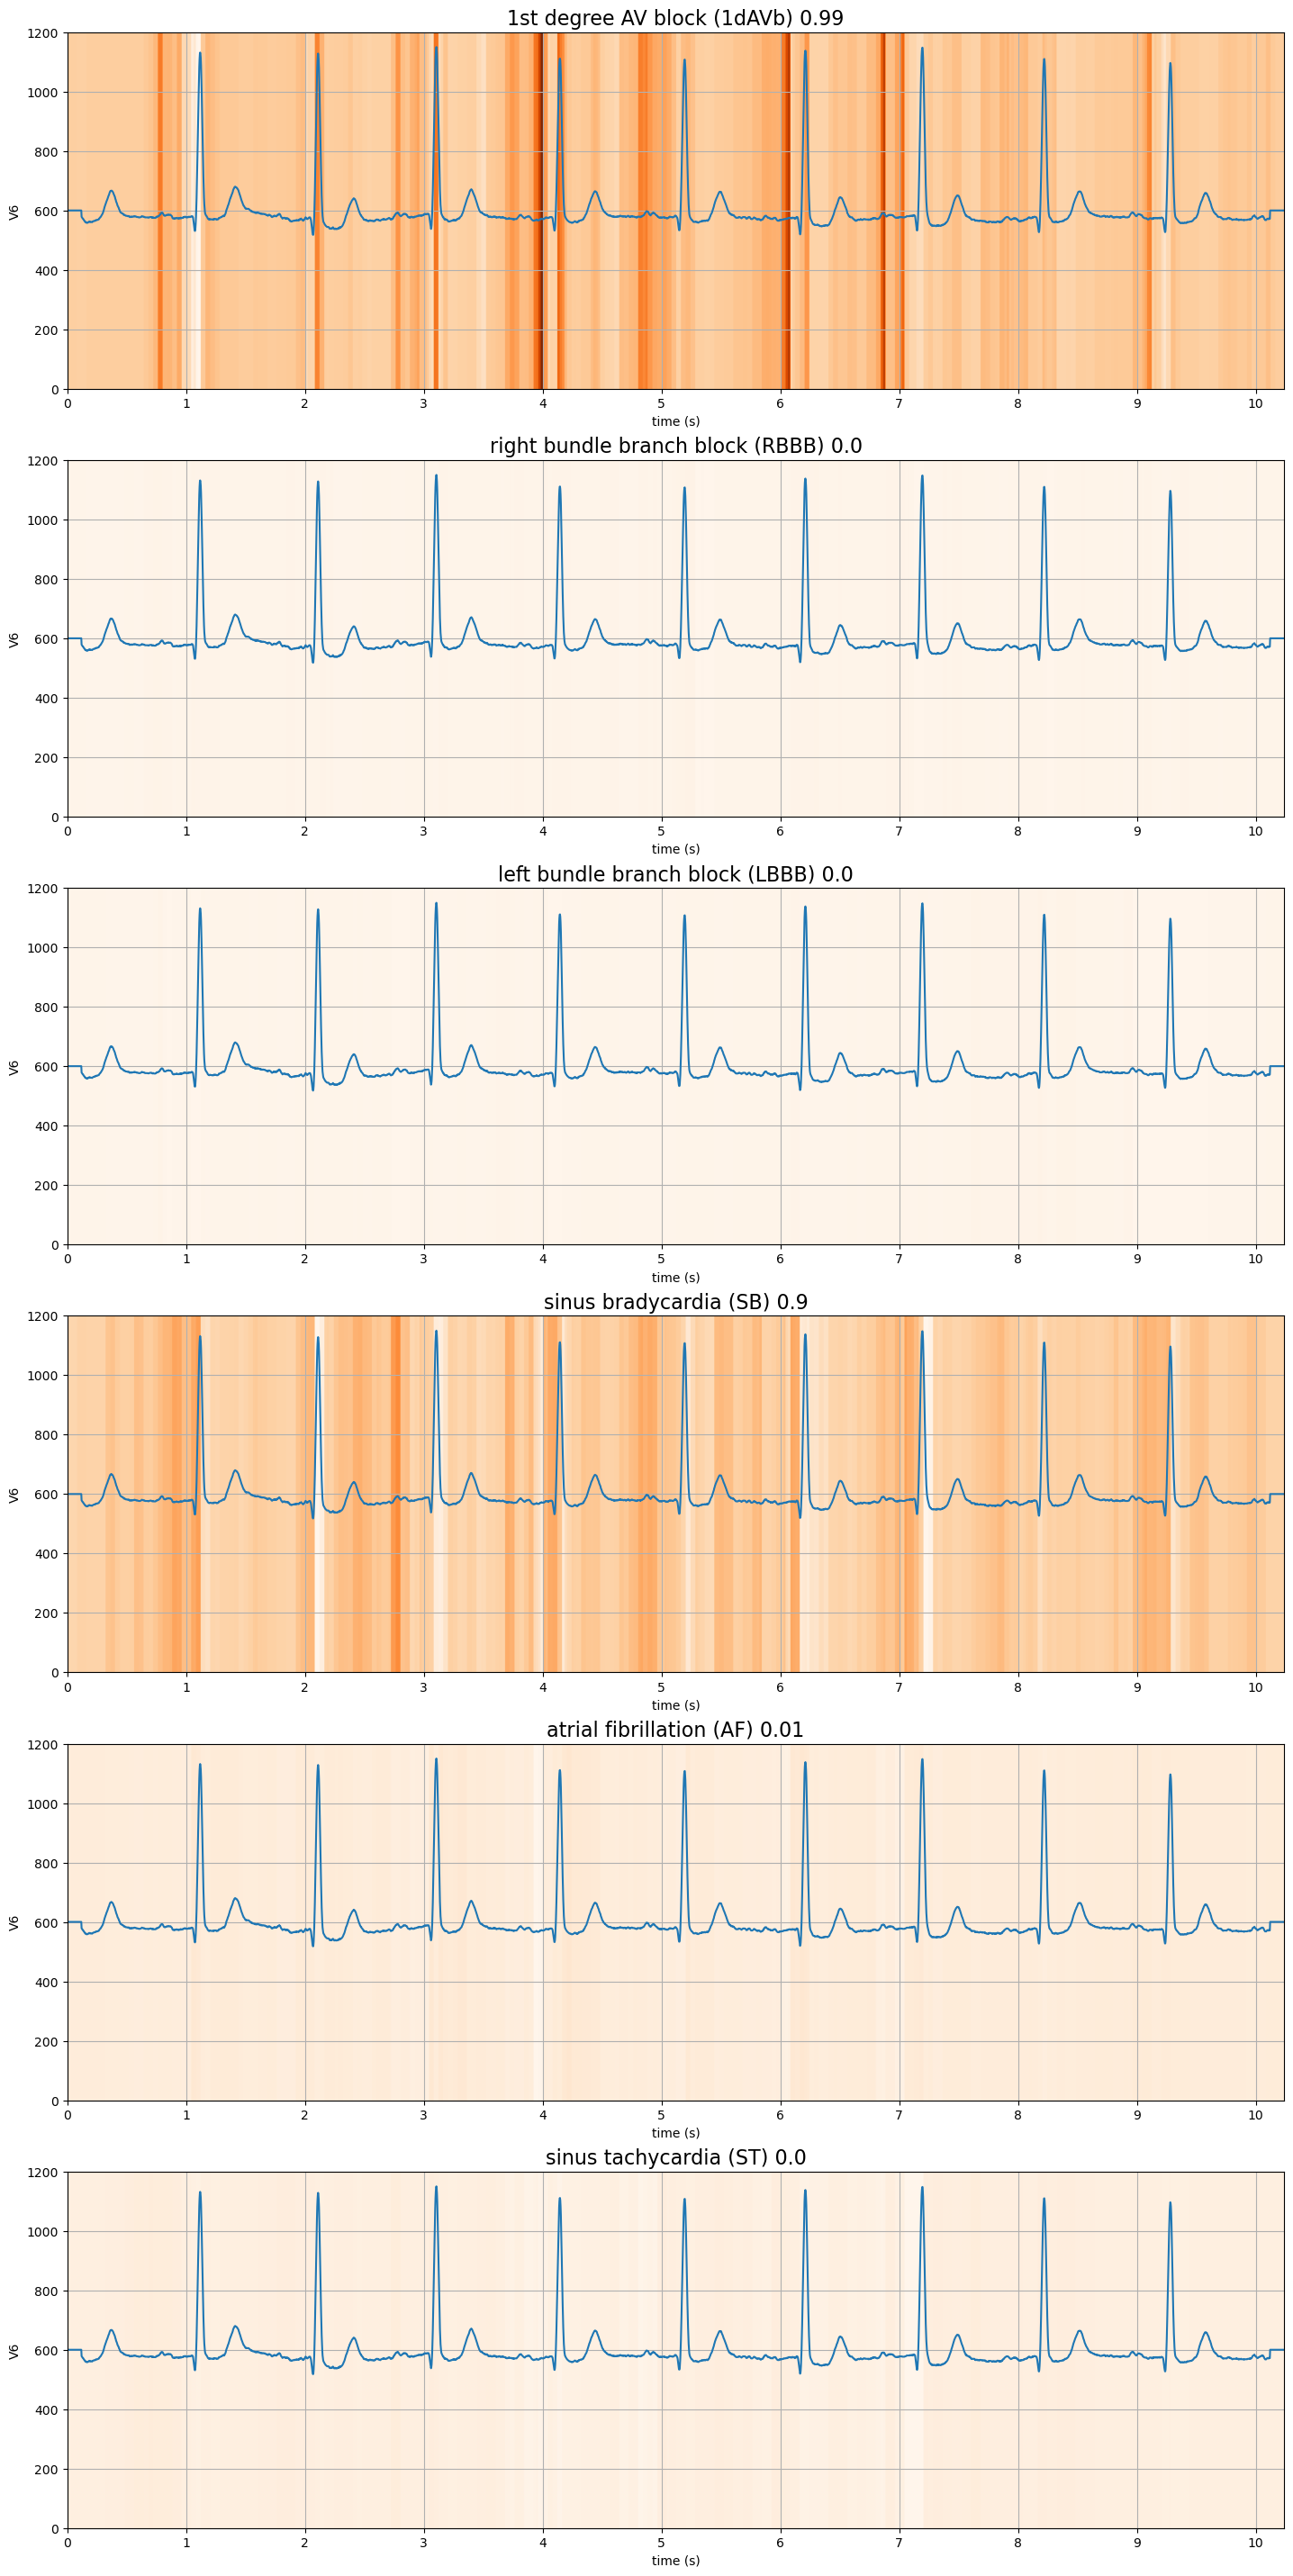

In [236]:
visualize_shap(X_ecg[50], 11)

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [03:52, 232.28s/it]                                    


7.856331620498875e-05


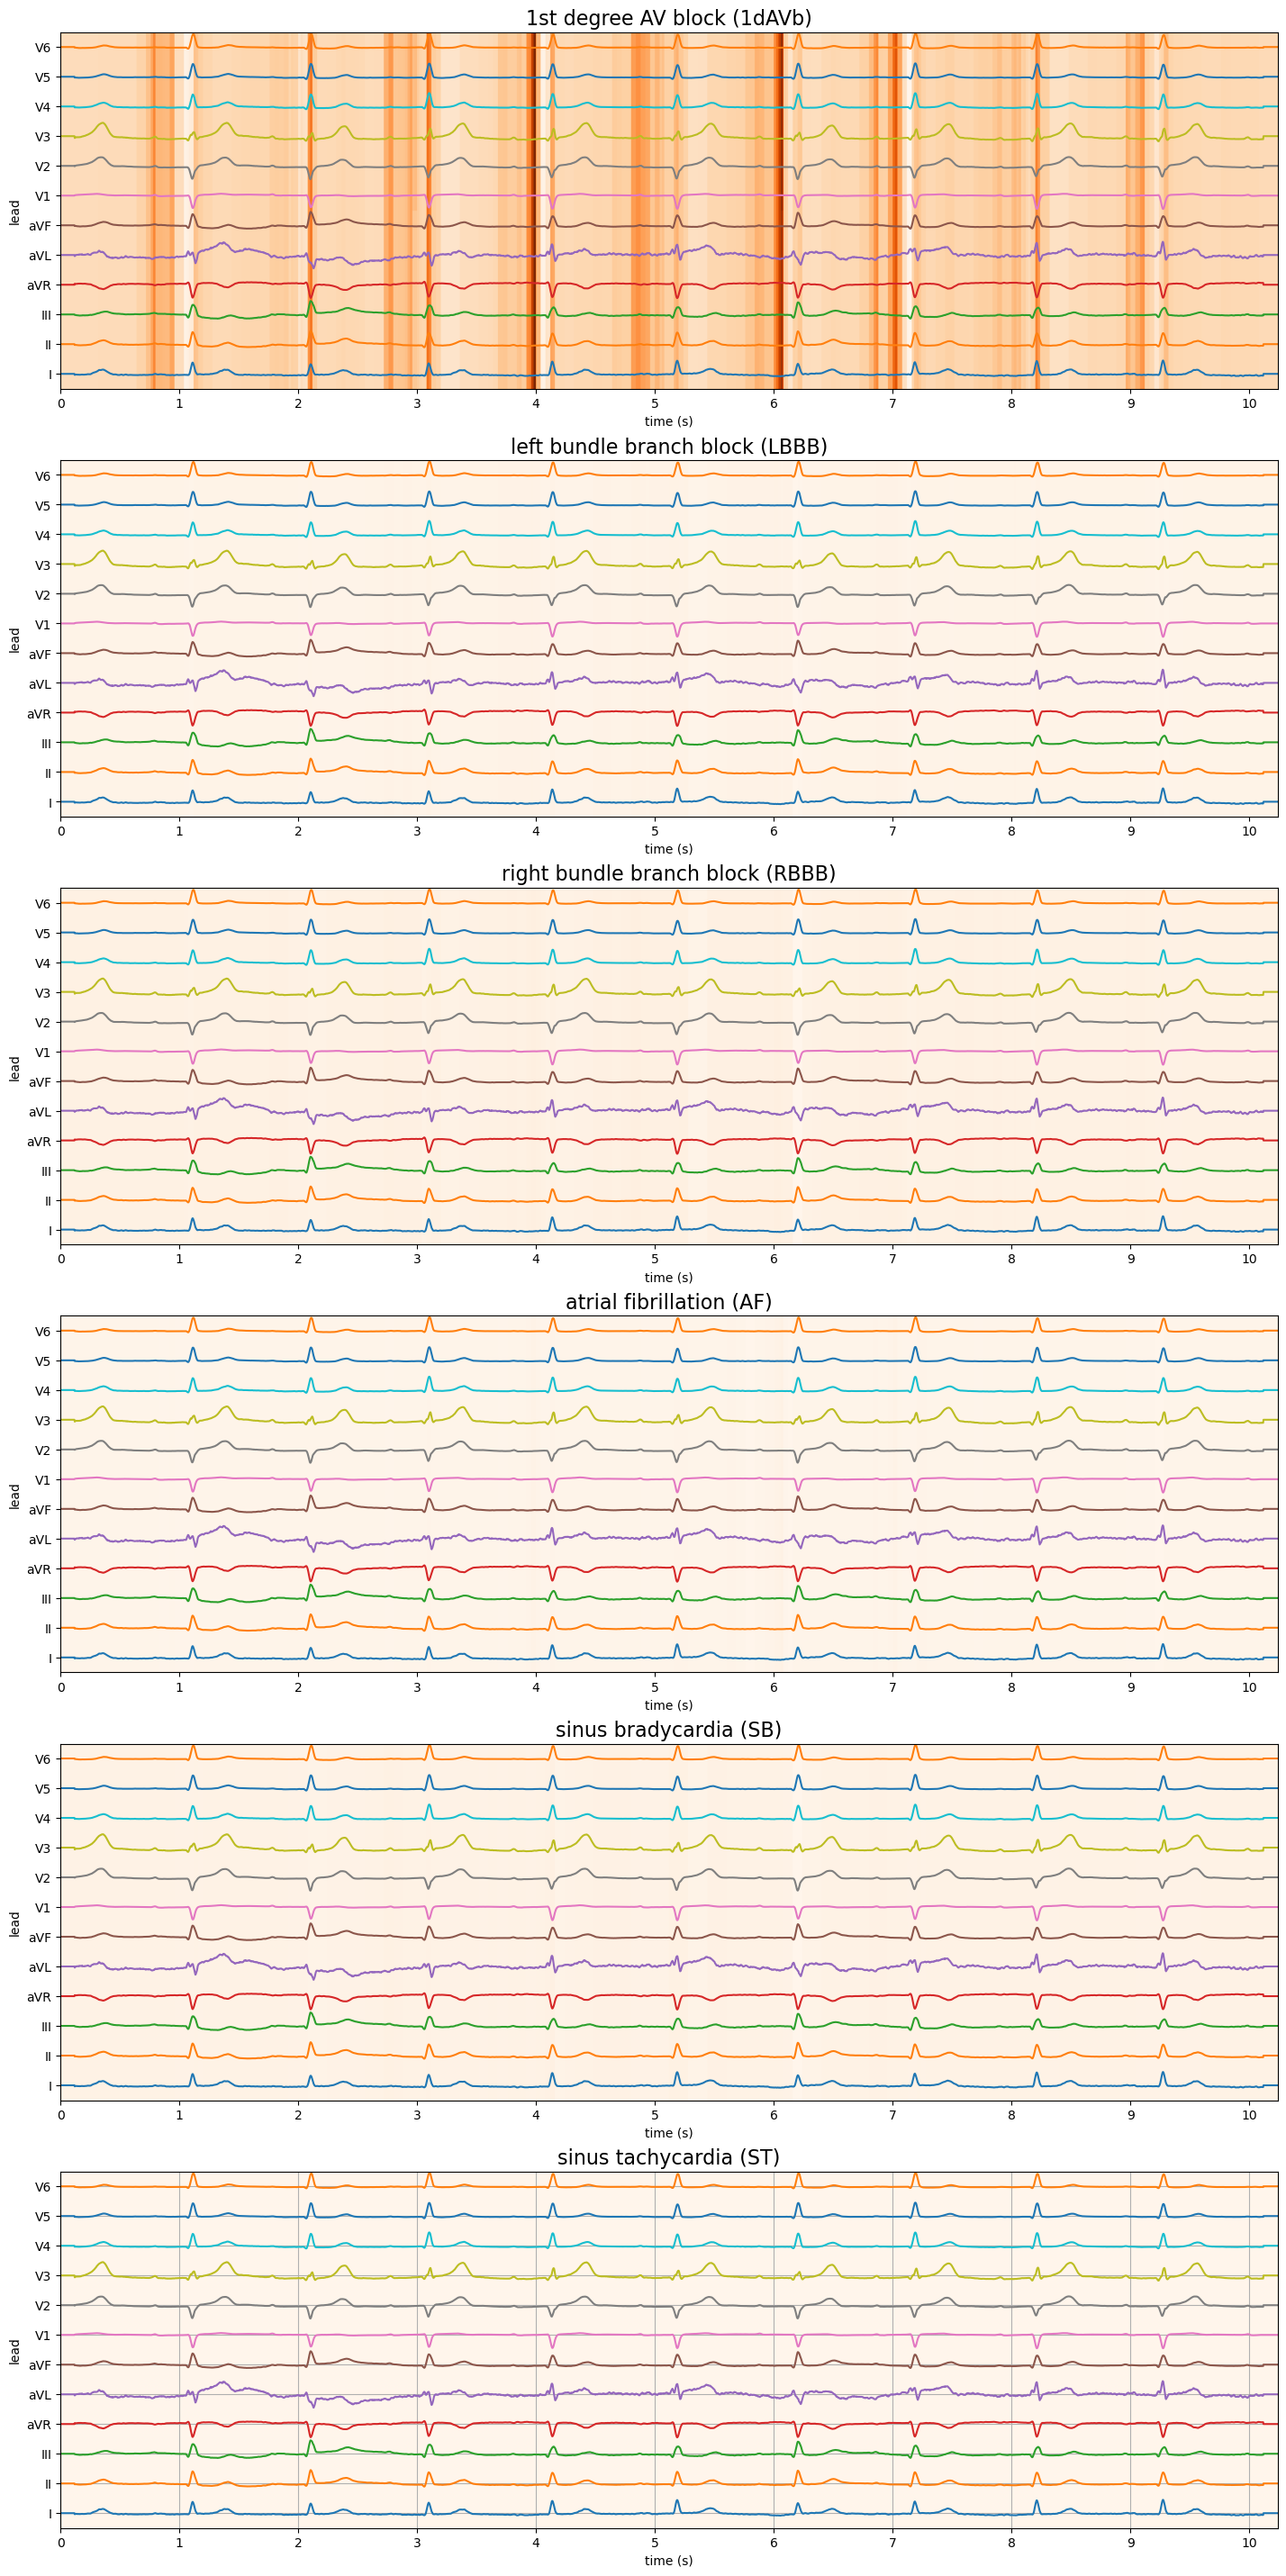

In [160]:
visualize_shap(X_ecg[50])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [03:57, 237.97s/it]                                                                                                                                                                                                  


['1st degree AV block (1dAVb)', 'right bundle branch block (RBBB)', 'left bundle branch block (LBBB)', 'sinus bradycardia (SB)', 'atrial fibrillation (AF)', 'sinus tachycardia (ST)']
(1, 4096, 12, 3, 6)
(1200, 4096)
(1200, 4096)
(1200, 4096)
(1200, 4096)
(1200, 4096)
(1200, 4096)


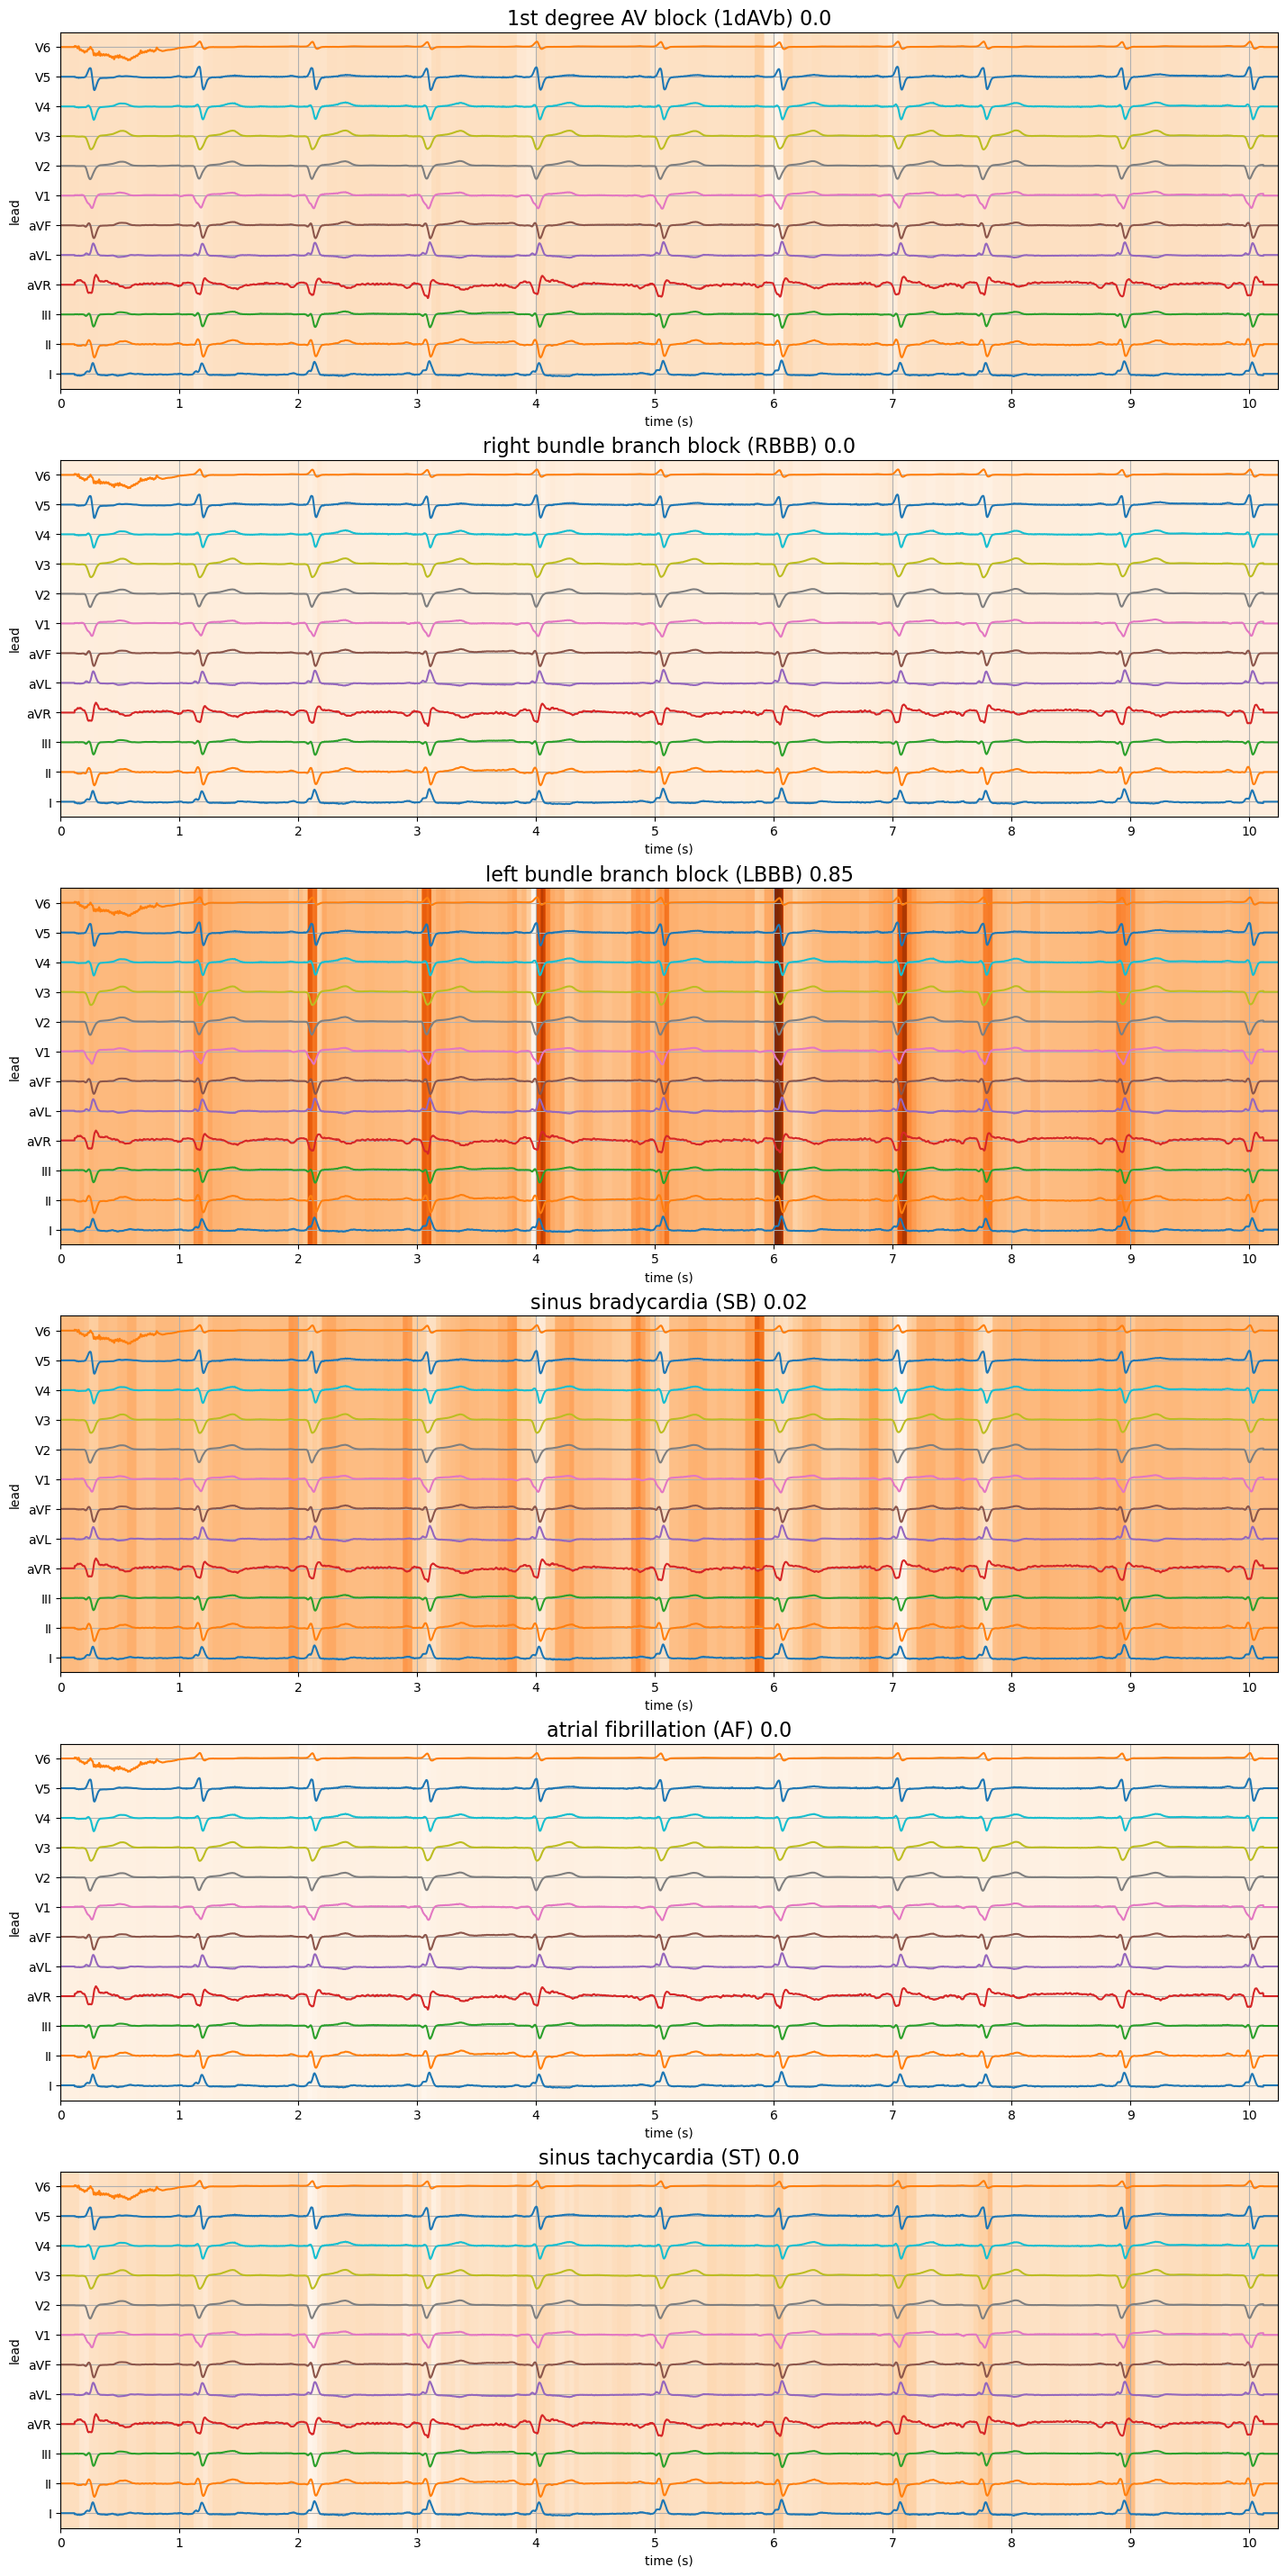

In [237]:
visualize_shap(X_ecg[803])

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


0.0008044659448495164


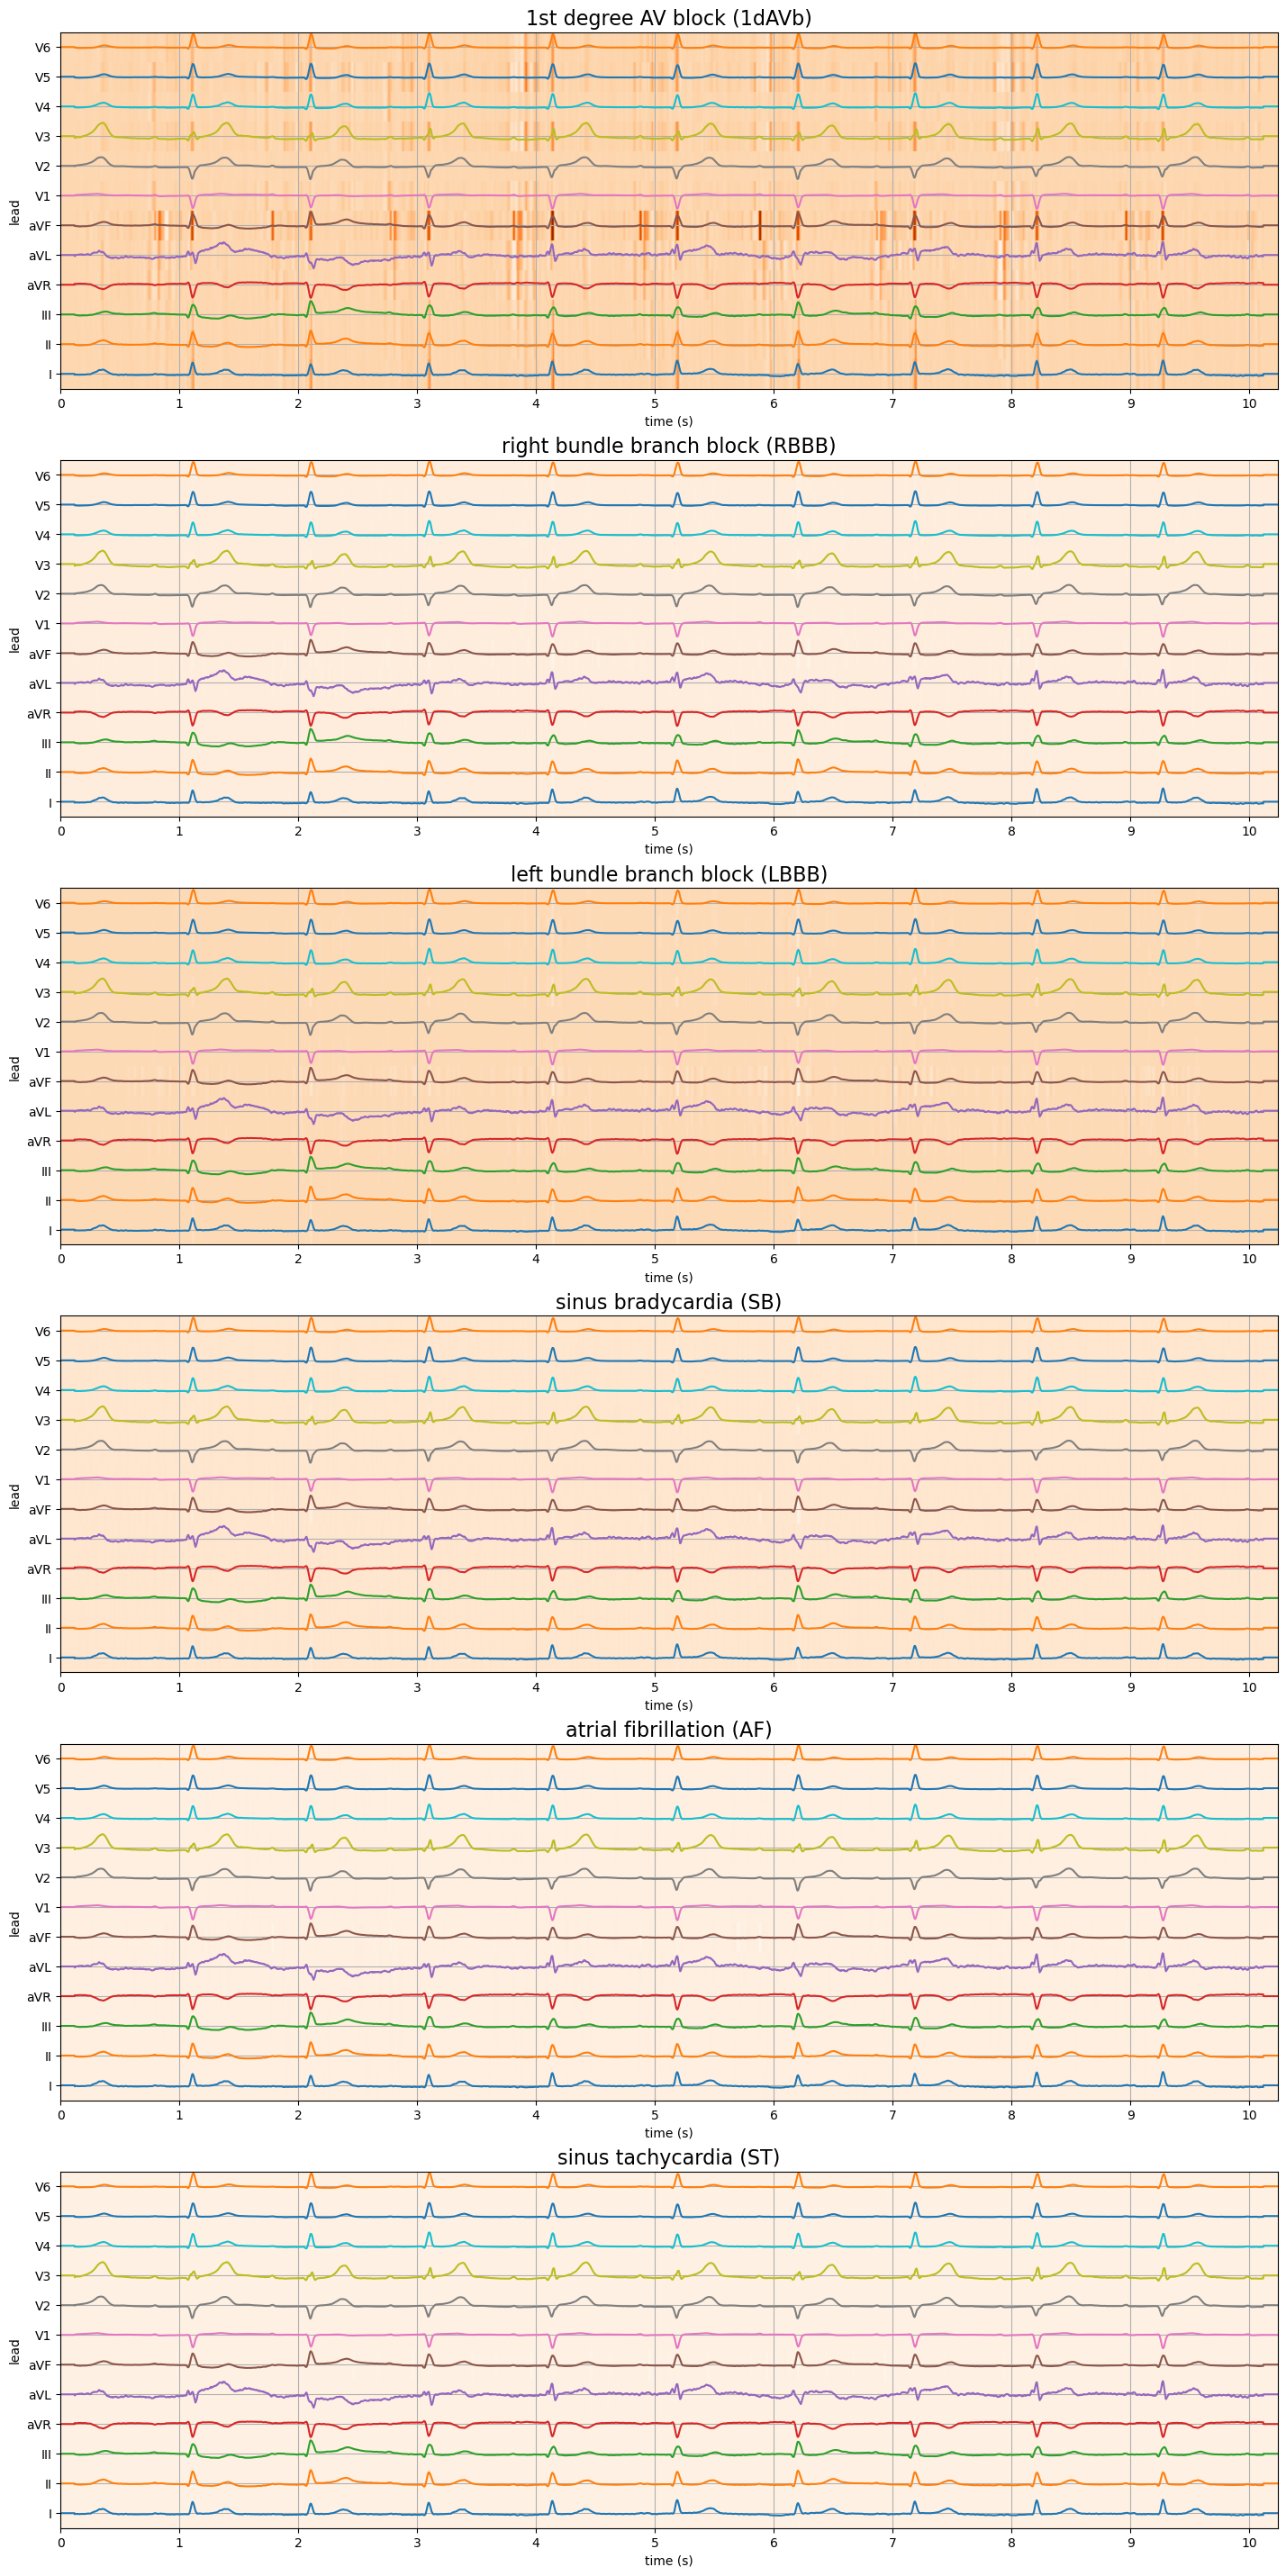

In [130]:
visualize_shap_deep(X_ecg[50])

In [3]:
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm

def load_raw_data(df, sampling_rate, path):
    data = []
    for f in df.filename_hr:
        data.append(wfdb.rdsamp(path+f)[0])
    return np.array(data)

path = 'data/ptbxl/'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id').sample(5000)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
print('read annotation')

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
print('loaded raw data')
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10


read annotation
loaded raw data


In [4]:
X.shape

(5000, 5000, 12)

In [5]:
Y.scp_codes

ecg_id
18157    {'IMI': 100.0, 'IVCD': 100.0, 'ABQRS': 0.0, 'S...
4744                          {'NORM': 80.0, 'SBRAD': 0.0}
13907                           {'NST_': 100.0, 'SR': 0.0}
16283                           {'NORM': 100.0, 'SR': 0.0}
7152     {'IMI': 100.0, 'IVCD': 100.0, 'ABQRS': 0.0, 'S...
                               ...                        
16921                           {'NORM': 100.0, 'SR': 0.0}
5552                            {'NORM': 100.0, 'SR': 0.0}
11232                             {'IMI': 15.0, 'SR': 0.0}
6790                          {'NDT': 100.0, 'LVH': 100.0}
11768                         {'NORM': 80.0, 'SARRH': 0.0}
Name: scp_codes, Length: 5000, dtype: object

In [6]:
Y = Y['scp_codes']

In [38]:
Y_ground = []
for y in Y:
    y_gr = [i in y and y[i] >= 10 for i in ['1AVB', 'CRBBB', 'CLBBB', 'SBRAD', 'AFIB', 'STACH']]
    Y_ground.append(y_gr)

In [39]:
Y_ground = np.array(Y_ground)

In [40]:
Y_ground.shape

(5000, 6)

In [41]:
model = utils.load_ribeiro_model()

In [42]:
X_ecg = utils.preprocess_ecg(X, ampl_ratio=7)

In [43]:
X_ecg.max()

323.26053145877813

In [25]:
Y_ecg = model.predict(X_ecg)

157/157 [==============================] - 184s 1s/step


In [22]:
Y_ecg

array([[1.5465660e-03, 6.0037397e-05, 1.0360963e-01, 1.1206885e-07,
        7.2844756e-05, 3.7534471e-06],
       [3.9648265e-05, 7.4508112e-05, 4.2943245e-07, 7.2280878e-01,
        1.7782198e-05, 9.8489998e-09],
       [1.6334652e-06, 9.6789006e-07, 2.7002445e-06, 9.6048007e-06,
        6.4986909e-07, 1.6612210e-08],
       ...,
       [6.5907508e-02, 1.3283872e-05, 5.8520109e-06, 5.3669606e-05,
        2.8257593e-05, 2.7988614e-08],
       [4.0188988e-06, 6.5140421e-07, 1.0071464e-06, 5.0258572e-05,
        1.2500496e-06, 3.1766412e-08],
       [9.2252681e-12, 6.1322217e-14, 4.1914400e-15, 2.7680215e-12,
        3.0071069e-12, 5.9754779e-12]], dtype=float32)

In [26]:
print('F1 Score for black-box model:', '\n')
for i in range(6) :
    print(utils.LABELS[i], '\t', f1_score(Y_ground[:, i], Y_ecg[:, i] > 0.5))

F1 Score for black-box model: 

1dAVb 	 0.40955631399317405
RBBB 	 0.6375545851528385
LBBB 	 0.8561403508771931
SB 	 0.0
AF 	 0.09448818897637797
ST 	 0.030534351145038167
